In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

class VAE(nn.Module):
    def __init__(self, input_size, hidden_size, latent_size, num_layers):
        super(VAE, self).__init__()
        
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.latent_size = latent_size
        self.num_layers = num_layers
        
        # Encoder
        self.encoder_lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc_mu = nn.Linear(hidden_size, latent_size)
        self.fc_logvar = nn.Linear(hidden_size, latent_size)
        
        # Decoder
        self.decoder_lstm = nn.LSTM(latent_size, hidden_size, num_layers, batch_first=True)
        self.fc_output = nn.Linear(hidden_size, input_size)
        
    def encode(self, x):
        _, (h_n, _) = self.encoder_lstm(x)
        h_n = h_n[-1]  # Take the last layer's hidden state
        mu = self.fc_mu(h_n)
        logvar = self.fc_logvar(h_n)
        return mu, logvar
    
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std
    
    def decode(self, z, seq_len):
        z = z.unsqueeze(1).repeat(1, seq_len, 1)
        output, _ = self.decoder_lstm(z)
        return self.fc_output(output)
    
    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z, x.size(1)), mu, logvar

# Assuming you have a DataLoader called train_loader
# train_loader = DataLoader(your_dataset, batch_size=batch_size, shuffle=True)

# Uncomment the following line to start training
# train(model, optimizer, train_loader, num_epochs)

In [2]:
from ngsim_dataset import NGSIMDataset
# settings for data loader
class DataSettings:
    def __init__(self):
        # location of datasets and category
        end_name = 'ngsim_sample.csv' # dataset name
        data_file = end_name # dataset category and dataset name
        # key = 'realKnownCause/'+end_name # This key is used for reading anomaly labels
        
        self.BASE = '/workspace/ClaudeTANOGAN/NGSIM_Dataset'
        # self.BASE = '/Users/thinhhoang/Documents/TAnoGAN/NGSIM_Dataset'
        # check if self.BASE has the last '/'
        if self.BASE[-1] != '/':
            self.BASE += '/'
        # self.label_file = 'labels\\combined_windows.json'
        self.data_file = data_file
        # self.key = key
        self.train = True
        self.window_length = 60
        self.column_name = 'Velocity'

dataset = NGSIMDataset(data_settings = DataSettings())
print(f'Shape of dataset: {dataset.x.shape}')

Select column name: Velocity
Shape of dataset: torch.Size([1800, 60, 1])


In [3]:
import torch.nn.functional as F
from torch.optim.lr_scheduler import StepLR

# Hyperparameters
input_size = 1  # Assuming univariate time series
hidden_size = 16
latent_size = 4
num_layers = 2
sequence_length = 60
batch_size = 32
initial_learning_rate = 1e-3
num_epochs = 300

# Learning rate decay parameters
lr_step_size = 30  # Decay the learning rate every 30 epochs
lr_gamma = 0.1  # Multiply the learning rate by 0.1 at each step


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Model, loss, and optimizer
model = VAE(input_size, hidden_size, latent_size, num_layers).to(device)
optimizer = optim.Adam(model.parameters(), lr=initial_learning_rate)
scheduler = StepLR(optimizer, step_size=lr_step_size, gamma=lr_gamma)


# Loss function
def loss_function(recon_x, x, mu, logvar):
    MSE = F.mse_loss(recon_x, x, reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return MSE + KLD

# Training loop
def train(model, optimizer, train_loader, num_epochs):
    model.train()
    for epoch in range(num_epochs):
        total_loss = 0
        for batch in train_loader:
            batch = batch.to(device)
            optimizer.zero_grad()
            recon_batch, mu, logvar = model(batch)
            loss = loss_function(recon_batch, batch, mu, logvar)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        scheduler.step()
        
        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {total_loss/len(train_loader):.4f}')

train_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)
train(model, optimizer, train_loader, num_epochs)


Using device: cuda
Epoch 1/300, Loss: 153.0994
Epoch 2/300, Loss: 102.9250
Epoch 3/300, Loss: 95.9954
Epoch 4/300, Loss: 77.7045
Epoch 5/300, Loss: 70.7553
Epoch 6/300, Loss: 68.9621
Epoch 7/300, Loss: 63.6642
Epoch 8/300, Loss: 61.5871
Epoch 9/300, Loss: 60.8824
Epoch 10/300, Loss: 59.4517
Epoch 11/300, Loss: 59.4983
Epoch 12/300, Loss: 59.1841
Epoch 13/300, Loss: 59.9677
Epoch 14/300, Loss: 59.1576
Epoch 15/300, Loss: 58.1451
Epoch 16/300, Loss: 57.5450
Epoch 17/300, Loss: 58.0166
Epoch 18/300, Loss: 58.3294
Epoch 19/300, Loss: 57.0406
Epoch 20/300, Loss: 58.3776
Epoch 21/300, Loss: 56.4338
Epoch 22/300, Loss: 57.8733
Epoch 23/300, Loss: 57.1352
Epoch 24/300, Loss: 57.4206
Epoch 25/300, Loss: 56.3715
Epoch 26/300, Loss: 56.6126
Epoch 27/300, Loss: 56.7475
Epoch 28/300, Loss: 57.4485
Epoch 29/300, Loss: 56.2805
Epoch 30/300, Loss: 55.4940
Epoch 31/300, Loss: 55.5403
Epoch 32/300, Loss: 54.3705
Epoch 33/300, Loss: 54.7045
Epoch 34/300, Loss: 54.6390
Epoch 35/300, Loss: 54.9361
Epoch 36

Generated 5 time series of length 60:
Sample 1:
[0.10352717 0.1844072  0.2559303  0.3131781  0.35785577 0.39234442
 0.41874388 0.43881074 0.4539879  0.4654329  0.47405255 0.48054376
 0.48543563 0.48912698 0.49191707 0.49403048 0.49563524 0.4968572
 0.49779078 0.49850658 0.49905762 0.49948373 0.49981478 0.50007325
 0.5002762  0.5004363  0.5005634  0.50066483 0.50074613 0.5008118
 0.50086504 0.5009085  0.50094396 0.5009732  0.5009974  0.50101745
 0.501034   0.50104797 0.50105965 0.5010694  0.50107765 0.50108457
 0.5010904  0.5010954  0.5010996  0.50110316 0.5011062  0.50110877
 0.50111103 0.5011128  0.5011145  0.5011158  0.501117   0.501118
 0.5011189  0.5011196  0.50112027 0.5011208  0.5011213  0.50112164]

Sample 2:
[-0.04007775 -0.07582495 -0.07870819 -0.07007132 -0.06000176 -0.05174369
 -0.04575908 -0.04166624 -0.03895269 -0.03718567 -0.03604728 -0.03531843
 -0.03485318 -0.03455631 -0.03436659 -0.03424497 -0.03416665 -0.03411594
 -0.03408293 -0.0340613  -0.03404705 -0.03403762 -0.034

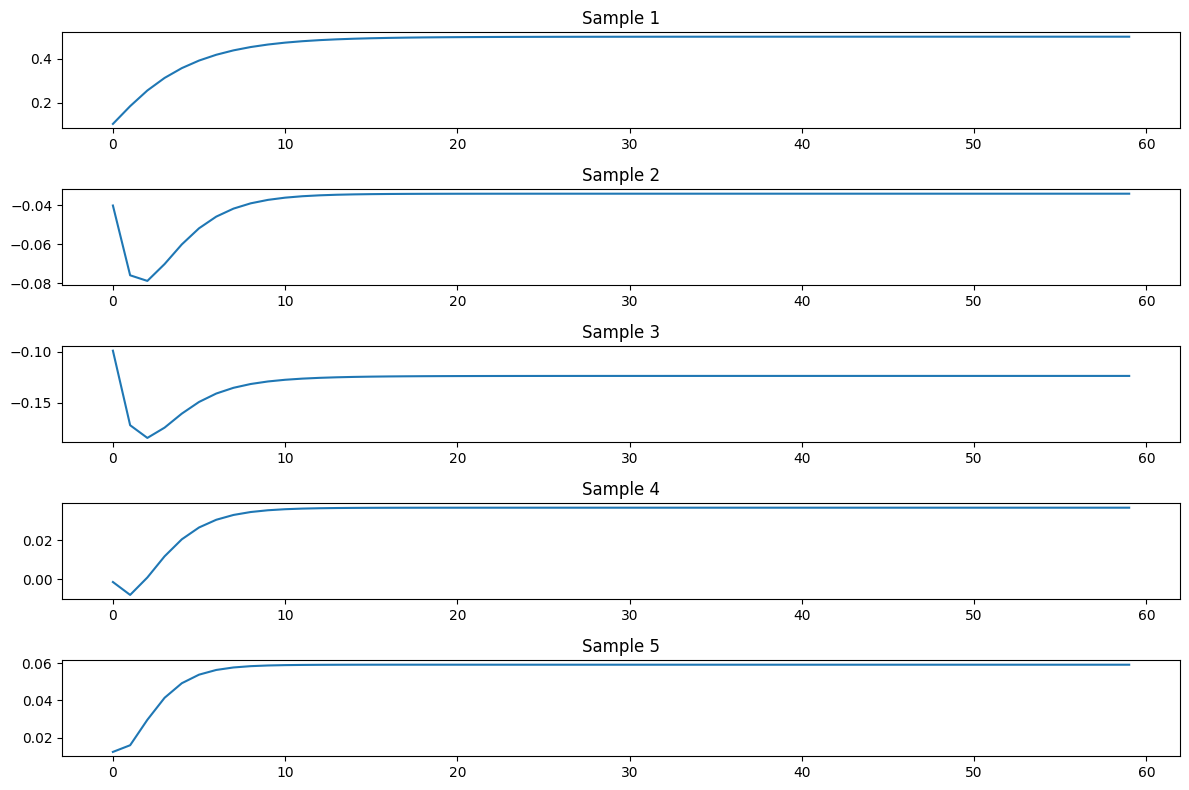

In [5]:
# Function to sample time series from the decoder
def sample_time_series(model, num_samples, seq_len):
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():  # No need to track gradients
        # Sample from the latent space
        z = torch.randn(num_samples, model.latent_size).to(device)
        
        # Generate time series using the decoder
        sampled_series = model.decode(z, seq_len)
        
    return sampled_series.cpu().numpy()

# Example usage of the sampling function
def demonstrate_sampling(model, num_samples=5, seq_len=60):
    sampled_series = sample_time_series(model, num_samples, seq_len)
    
    print(f"Generated {num_samples} time series of length {seq_len}:")
    for i, series in enumerate(sampled_series):
        print(f"Sample {i+1}:")
        print(series.flatten())  # Flatten the series for easier viewing
        print()

    # You could also visualize these series using matplotlib
    import matplotlib.pyplot as plt
    plt.figure(figsize=(12, 8))
    for i, series in enumerate(sampled_series):
        plt.subplot(num_samples, 1, i+1)
        plt.plot(series.flatten())
        plt.title(f"Sample {i+1}")
    plt.tight_layout()
    plt.show()

demonstrate_sampling(model)

In [7]:
def save_model(model, filepath):
    """
    Save the model weights to a file.
    
    Args:
    model (nn.Module): The model whose weights will be saved
    filepath (str): The path where the weights will be saved
    """
    torch.save(model.state_dict(), filepath)
    print(f"Model weights saved to {filepath}")
save_model(model, "vae.pth")

Model weights saved to vae.pth
